# Elliptic woth Neumann boundary conditions

We aim to solve an elliptic linear PDE of the form 

$$
Lu = \xi \\
\nabla u \cdot  \bold{n}= \frac{\partial}{\partial \bold{n}}u=0
$$

We need to form the matrix 

$$
\Theta = \begin{bmatrix}
  \frac{\partial}{\partial \bold{n}_x} \frac{\partial}{\partial \bold{n}_y} K(X_{\partial\Omega},X_{\partial\Omega}) & \int L_y  \frac{\partial}{\partial \bold{n}_x} K(X_{\partial\Omega}, y)\psi \\
\int L_y \frac{\partial}{\partial \bold{n}_x}  K(X_{\partial\Omega}, y)\psi ^\intercal & \int \int  L_y L_x K( x, y) \psi(x)\psi(y)
\end{bmatrix}
$$

In [1]:
from utils_elliptic_coef_neumann import *

import jax.numpy as jnp
from jax import jit, vmap

import matplotlib.pyplot as plt 

from jax import grad

from jax.config import config
config.update("jax_enable_x64", True)

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_24132\2803774131.py:10: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [38]:
def grad_matern_kernel_x(x, y, length_scale):
    nabla = grad(matern_kernel, argnums = 0)(x, y, length_scale)
    nabla = jnp.where(jnp.allclose(x,y), 0, nabla)

    return nabla

def double_grad_matern_kernel(x, y, length_scale):
    nabla = grad(grad_matern_kernel_x, argnums = 1)(x, y, length_scale)
    nu = 5/2
    nabla = jnp.where(jnp.allclose(x,y), -2*nu/(2*(1-nu)*length_scale), nabla)

    return nabla

vmap_grad_matern_kernel = vmap(vmap(double_grad_matern_kernel, in_axes = (0, None, None)), in_axes = (None, 0, None))

In [39]:
x = jnp.linspace(0, 1, 1000)
length_scale = 1.0
x

Array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
       0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
       0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
       0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
       0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
       0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
       0.07007007, 0.07107107, 0.07207207, 0.07307307, 0.07407

In [40]:
grad_matern_kernel_x(x[0], x[2], length_scale)

Array(0.00333664, dtype=float64)

In [41]:
double_grad_matern_kernel(x[0], x[0], length_scale)

Array(1.66666667, dtype=float64)

In [42]:
K_grad = vmap_grad_matern_kernel(x, x, length_scale)
K = vmap_kernel(x, x, length_scale)

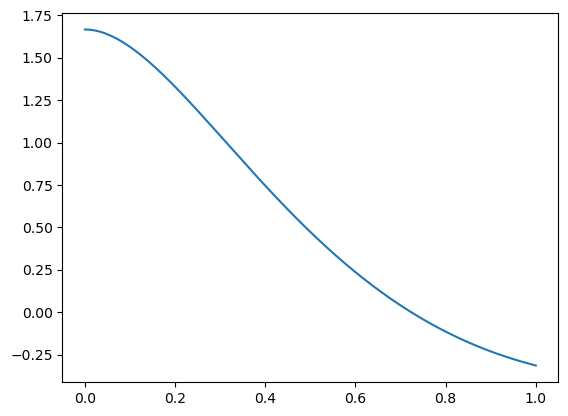

In [43]:
plt.plot(x, K_grad[0])

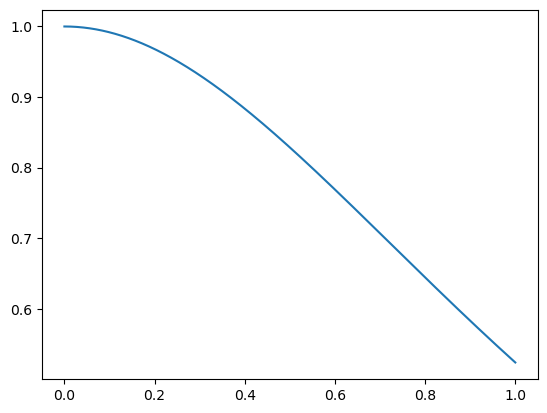

In [44]:
plt.plot(x, K[0])